# LAPD crimes database: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import weightedcalcs as wc
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
# https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/63jg-8b9z
src = pd.read_csv('/Users/mhustiles/data/data/LA/Crime_Data_from_2010_to_Present.csv')

In [3]:
crimes = src

In [4]:
crimes.columns = crimes.columns.str.strip().str.lower()\
.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### These data are super messy...

In [5]:
crimes.rename(columns = { 
'dr_no':'record_id',
'date_rptd':'date_reported',
'date_occ':'date_occurred',
'time_occ':'time_occurred',
'area':'division',
'area_name':'division_name',
'rpt_dist_no':'reporting_district',
'part_1-2':'part_type',
'crm_cd':'crime_code',
'crm_cd_desc':'crime_code_description',
'mocodes':'modus_operandi_code',
'vict_age':'victim_age',
'vict_sex':'victim_sex',
'vict_descent':'victim_descent',
'premis_cd':'premises_code',
'premis_desc':'premises_description',
'weapon_used_cd':'weapon_code',
'weapon_desc':'weapon_description',
'status':'status_code',
'status_desc':'status_code_description',
'crm_cd_1':'crm_cd_1',
'crm_cd_2':'crm_cd_2',
'crm_cd_3':'crm_cd_3',
'crm_cd_4':'crm_cd_4',
'location':'address',
'cross_street':'cross_street',
'lat':'latitude',
'lon':'longitude',
 }, inplace = True)

### ... contunued

In [6]:
crimes['date_reported'] = crimes['date_reported'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = crimes['date_occurred'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = pd.to_datetime(crimes['date_occurred'], format='%m/%d/%Y')
crimes['year'] = crimes['date_occurred'].dt.year
crimes['quarter'] = crimes['date_occurred'].dt.quarter
crimes['day'] = crimes['date_occurred'].dt.day
crimes['month'] = crimes['date_occurred'].dt.month
crimes['weekday'] = crimes['date_occurred'].dt.weekday_name
crimes['monthname'] = crimes['date_occurred'].dt.month_name()

In [7]:
crimes[[ 'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month', ]] = crimes[[
    'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month',]].astype(str)

In [8]:
descent_recode = { 'A':"Asian",'B':"Black",'C':"Asian",'D':"Asian",'F':"Asian",'G':"Asian",\
                 'H':"Hispanic",'I':"American Indian/Alaskan Native",'J':"Asian",\
                 'K':"Asian",'L':"Asian",'O':"Other",'P':"Asian",'S':"Asian",\
                 'U':"Asian",'V':"Asian",'W':"White",'X':"Other",'Z':"Asian" }

In [9]:
crimes['descent_description'] = crimes['victim_descent'].map(descent_recode)

In [10]:
victim_sex_recode = { 'F':"Female",'M':"Male",'X':"Unknown",'-':"Unknown",'N':"Unknown",'H':"Unknown" }

In [11]:
crimes['victim_sex'] = crimes['victim_sex'].map(victim_sex_recode)

In [12]:
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['crm_cd_1'] = crimes['crm_cd_1'].str.replace('.0','', regex=False)
crimes['crm_cd_2'] = crimes['crm_cd_2'].str.replace('.0','', regex=False)

In [13]:
crimes['premises_description'] = crimes['premises_description'].str.capitalize()
crimes['crime_code_description'] = crimes['crime_code_description'].str.capitalize()
crimes['weapon_description'] = crimes['weapon_description'].str.capitalize()

In [14]:
monthnames = ['January','February','March','April','May','June','July','August','September','October','November','December']

In [15]:
crimes['time_occurred'] = crimes['time_occurred'].str.replace('.0','', regex=False)
crimes['time_occurred'] = crimes['time_occurred'].str.zfill(4)
crimes['hour'] = crimes['time_occurred'].str[:2]
crimes['minute'] = crimes['time_occurred'].str[2:]
crimes = crimes[crimes['hour'] != '0n']
crimes = crimes[crimes['hour'] != '24']

In [16]:
homicides = crimes[crimes['crime_code_description'].str.contains('CRIMINAL HOMICIDE', na=False)]

---

## Now that it's clean, what can we learn from this data?

### Share of crimes by UCR type

In [17]:
crimes['part_type'].value_counts('normalize').round(3)*100

1    55.4
2    44.6
Name: part_type, dtype: float64

In [18]:
cases_grouped = crimes.groupby(['crime_code_description', 'part_type', 'victim_sex'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

### Cases involving suspects or victimes defined by LAPD as 'homeless'

In [19]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [20]:
mocodes = pd.read_csv('mo_codes.csv')
mocodes.head()

mo_code  mo_code_description
0    0100  Suspect Impersonate
1    0101           Aid victim
2    0102                Blind
3    0103             Crippled
4    0104             Customer

### Isolating just cases involving homeless people

In [21]:
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

mo_code            mo_code_description
361    1218  Victim was Homeless/Transient
521    2004  Suspect is homeless/transient

### Limit homeless crime data to recent years to account for LAPD coding priorities

In [22]:
homeless_dates = ['2017', '2018', '2019']

### Various filters filters for homeless residents

In [23]:
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) \
                          & (crimes['year'].isin(homeless_dates))]

In [24]:
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) \
                           & (crimes['year'].isin(homeless_dates))]

In [25]:
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('Criminal homicide', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [26]:
homeless_victims_women = homeless_victims[homeless_victims['victim_sex'] == 'F']

---

## Geography

### Read city of Los Angeles boundary file

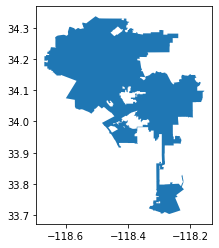

In [27]:
la = gpd.read_file('input/la_city_boundary/la_city_boundary_1570551157861.geojson')
la.plot()

In [67]:
# http://geohub.lacity.org/datasets/c493f3d44e97482e90ce9355019b1349_158
shelters_src = gpd.read_file('input/Homeless_Shelters_and_Services/Homeless_Shelters_and_Services.shp')

In [68]:
shelters = shelters_src[shelters_src['latitude'] > 28]

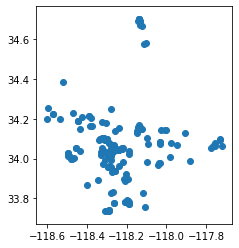

In [69]:
shelters.plot()

In [70]:
shelters.to_file('output/la_shelters.geojson', driver='GeoJSON')

In [71]:
shelters.head(2)

OBJECTID source ext_id             cat1                            cat2  \
0  149780041    211   None  Social Services  Homeless Shelters and Services   
1  149780371    211   None  Social Services  Homeless Shelters and Services   

   cat3             org_name  \
0  None                 None   
1  None  www.catalystfdn.org   

                                                Name               addrln1  \
0  Children's Hosptial Los Angeles - High Risk Yo...    5000 W Sunset Blvd   
1                          Catalyst Foundation , The  540 W Lancaster Blvd   

   addrln2         city state  \
0  4th Fl.  Los Angeles    CA   
1     None    Lancaster    CA   

                                               hours  \
0  Monday through Friday, 8:30am to 5:00pm.  Clin...   
1  Monday through Thursday, 8:00am to 5:00pm; Fri...   

                                              phones email  \
0  Administrative (323) 361-2390, Appointments Se...  None   
1  Service/Intake and Administration (661) 949-73...  None   

                                                 url info1 info2  post_id  \
0  www.childrenshospitalla.org/site/c.ipINKTOAJsG...  None  None      947   
1                                www.catalystfdn.org  None  None     1283   

                                          descriptio    zip  \
0  The agency provides health services and homele...  90027   
1  The foundation provides emergency food and HIV...  93534   

                                    link use_type   latitude   longitude  \
0   http://egis3.lacounty.gov/lms/?p=947  publish  34.097879 -118.298445   
1  http://egis3.lacounty.gov/lms/?p=1283  publish  34.697883 -118.138432   

                 date_updat dis_status       POINT_X       POINT_Y  \
0  2013-06-01T11:50:56.000Z       None  6.471317e+06  1.858135e+06   
1  2013-06-01T11:50:56.000Z       None  6.520061e+06  2.076384e+06   

                                       geometry  
0  POINT (-118.2984449559496 34.09787917653227)  
1   POINT (-118.138431956915 34.69788337567378)

---

### Set buffers around the shelters

In [72]:
shelters = shelters.to_crs({'init': 'epsg:3310'}, inplace=True)

In [73]:
shelters['geometry'] = shelters.buffer(304.8)

AttributeError: 'NoneType' object has no attribute 'buffer'

In [35]:
shelters.to_file('output/la_shelters_buffers.geojson', driver='GeoJSON')

In [36]:
def adddummyfield(row):
    row['category'] = 'x'
    return row

In [37]:
dissolvedshelters = shelters.apply(adddummyfield, axis=1).dissolve('category')

In [38]:
dissolvedshelters.crs = ({'init': 'epsg:4326'})
dissolvedshelters.to_crs({'init': 'epsg:4326'})

geometry   OBJECTID source  \
category                                                                        
x         (POLYGON ((157065.7976506211 -473784.297089199...  149780041    211   

         ext_id             cat1                            cat2  cat3  \
category                                                                 
x          None  Social Services  Homeless Shelters and Services  None   

         org_name                                               Name  \
category                                                               
x            None  Children's Hosptial Los Angeles - High Risk Yo...   

                     addrln1  addrln2         city state  \
category                                                   
x         5000 W Sunset Blvd  4th Fl.  Los Angeles    CA   

                                                      hours  \
category                                                      
x         Monday through Friday, 8:30am to 5:00pm.  Clin...   

                                                     phones email  \
category                                                            
x         Administrative (323) 361-2390, Appointments Se...  None   

                                                        url info1 info2  \
category                                                                  
x         www.childrenshospitalla.org/site/c.ipINKTOAJsG...  None  None   

          post_id                                         descriptio    zip  \
category                                                                      
x             947  The agency provides health services and homele...  90027   

                                          link use_type   latitude  \
category                                                             
x         http://egis3.lacounty.gov/lms/?p=947  publish  34.097879   

           longitude                date_updat dis_status       POINT_X  \
category                                                                  
x        -118.298445  2013-06-01T11:50:56.000Z       None  6.471317e+06   

               POINT_Y  
category                
x         1.858135e+06

In [39]:
dissolvedshelters.to_file('output/dissolvedshelters.geojson', driver='GeoJSON')

### How many crimes plot inside the buffer areas?

In [40]:
crimes_gdf = gpd.GeoDataFrame(crimes, \
    geometry=gpd.points_from_xy(crimes.longitude, crimes.latitude))

In [41]:
crimes_clipped = gpd.sjoin(crimes_gdf, la, op = 'within')

//anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [42]:
crimes_clipped.drop(columns=['index_right'])

record_id date_reported date_occurred time_occurred division  \
0          1307355    02/20/2010    2010-02-20          1350       13   
1         11401303    09/13/2010    2010-09-12          0045       14   
2         70309629    08/09/2010    2010-08-09          1515       13   
3         90631215    01/05/2010    2010-01-05          0150        6   
4        100100501    01/03/2010    2010-01-02          2100        1   
5        100100506    01/05/2010    2010-01-04          1650        1   
6        100100508    01/08/2010    2010-01-07          2005        1   
7        100100509    01/09/2010    2010-01-08          2100        1   
8        100100510    01/09/2010    2010-01-09          0230        1   
9        100100511    01/09/2010    2010-01-06          2100        1   
10       100100521    01/14/2010    2010-01-14          1445        1   
11       100100522    01/15/2010    2010-01-14          2000        1   
12       100100523    01/15/2010    2010-01-15          0245        1   
13       100100529    01/16/2010    2010-01-15          1745        1   
14       100100531    01/16/2010    2010-01-15          2030        1   
15       100100535    01/17/2010    2010-01-16          1735        1   
16       100100552    01/23/2010    2010-01-23          1225        1   
17       100100553    01/23/2010    2010-01-23          1100        1   
18       100100555    01/23/2010    2010-01-23          2000        1   
19       100100561    01/26/2010    2010-01-26          1820        1   
20       100100562    01/28/2010    2010-01-28          2345        1   
21       100100564    01/30/2010    2010-01-29          1630        1   
22       100100570    01/31/2010    2010-01-31          0130        1   
23       100100571    01/31/2010    2010-01-31          1000        1   
24       100100572    02/01/2010    2010-01-31          1700        1   
25       100100573    02/01/2010    2010-01-31          2200        1   
26       100100574    02/01/2010    2010-01-31          1930        1   
27       100100575    02/01/2010    2010-01-31          1720        1   
28       100100578    02/05/2010    2010-02-03          1255        1   
29       100100580    02/02/2010    2010-02-01          1355        1   
30       100100581    02/05/2010    2010-02-05          1425        1   
31       100100586    02/06/2010    2010-02-06          0110        1   
32       100100587    02/05/2010    2010-02-05          2030        1   
33       100100591    02/10/2010    2010-02-08          1625        1   
34       100100592    02/08/2010    2010-02-08          1800        1   
35       100100608    02/11/2010    2010-02-10          1900        1   
36       100100610    02/11/2010    2010-02-10          1800        1   
37       100100616    02/11/2010    2010-02-11          1515        1   
38       100100622    02/13/2010    2010-02-13          0055        1   
39       100100623    02/13/2010    2010-02-13          0150        1   
40       100100628    02/15/2010    2010-02-14          1500        1   
41       100100630    02/15/2010    2010-02-15          0100        1   
42       100100632    02/16/2010    2010-02-16          1540        1   
43       100100633    02/17/2010    2010-02-17          1725        1   
44       100100634    02/20/2010    2010-02-19          2040        1   
45       100100635    02/20/2010    2010-02-19          2030        1   
46       100100638    02/20/2010    2010-02-20          0100        1   
47       100100639    02/20/2010    2010-02-20          0230        1   
48       100100642    02/21/2010    2010-02-21          0500        1   
49       100100650    02/25/2010    2010-02-25          0030        1   
50       100100651    02/26/2010    2010-02-25          2330        1   
51       100100654    02/27/2010    2010-02-27          1955        1   
52       100100655    02/28/2010    2010-02-28          0015        1   
53       100100657    03/01/2010    2010-02-28          2200       

In [43]:
crimes_clipped.crs = ({'init': 'epsg:3310'})

### How many homeless crimes plot inside the buffer areas?

In [44]:
homeless_suspects_gdf = gpd.GeoDataFrame(homeless_suspects, \
    geometry=gpd.points_from_xy(homeless_suspects.longitude, homeless_suspects.latitude))

In [45]:
homeless_suspects_gdf = gpd.sjoin(homeless_suspects_gdf, la, op = 'within')

In [46]:
homeless_suspects_gdf.drop(columns=['index_right'])

record_id date_reported date_occurred time_occurred division  \
1437675  171304592    01/10/2017    2017-01-10          1530       13   
1437676  170120212    07/20/2017    2017-07-20          1550        1   
1437722  170126156    10/03/2017    2017-10-03          1050        1   
1437732  171600882    06/29/2017    2017-06-29          1400       16   
1437800  171109384    04/22/2017    2017-04-22          0800       11   
1437810  170121605    08/06/2017    2017-08-06          1430        1   
1437856  170409856    05/11/2017    2017-05-11          0915        4   
1437867  171004783    01/18/2017    2017-01-18          1645       10   
1437885  170811061    06/03/2017    2017-06-03          2050        8   
1437892  170300946    09/09/2017    2017-09-09          1945        3   
1437900  170901546    09/14/2017    2017-09-14          1400        9   
1437963  171121330    12/27/2017    2017-12-26          1610       11   
1438052  172013626    07/09/2017    2017-07-09          1420       20   
1438068  171712802    06/16/2017    2017-06-16          0005       17   
1438219  170130349    11/26/2017    2017-11-26          1740        1   
1438236  171413323    05/28/2017    2017-05-28          1245       14   
1438252  171706765    02/22/2017    2017-02-22          1130       17   
1438316  170129174    11/10/2017    2017-11-10          0710        1   
1438329  171721317    11/28/2017    2017-11-20          1900       17   
1438330  170917479    09/18/2017    2017-09-18          1430        9   
1438472  170100934    06/20/2017    2017-06-20          1250        1   
1438554  171217787    07/10/2017    2017-07-10          1945       12   
1438575  170104916    01/16/2017    2017-01-16          1450        1   
1438586  170128053    10/27/2017    2017-10-27          0955        1   
1438601  171507707    03/04/2017    2017-03-04          1800       15   
1438646  171512536    05/26/2017    2017-05-26          2230       15   
1438650  171114906    08/10/2017    2017-08-10          1745       11   
1438685  170306347    02/06/2017    2017-02-06          1035        3   
1438693  171514475    07/01/2017    2017-07-01          1310       15   
1438730  170713836    08/07/2017    2017-08-07          1715        7   
1438753  170130341    11/26/2017    2017-11-26          1630        1   
1438769  171508032    03/10/2017    2017-03-10          0250       15   
1438821  170221528    12/04/2017    2017-12-04          0015        2   
1438828  170623589    11/13/2017    2017-11-13          1330        6   
1438836  170200782    06/12/2017    2017-06-10          1615        2   
1438869  171515401    07/17/2017    2017-07-17          2115       15   
1438876  171500903    07/12/2017    2017-07-12          1440       15   
1438939  170815652    09/16/2017    2017-09-16          1430        8   
1438959  170132669    12/26/2017    2017-12-26          1400        1   
1438971  170313954    05/29/2017    2017-05-29          0830        3   
1438988  171517704    08/27/2017    2017-08-27          1010       15   
1439043  170409419    05/02/2017    2017-05-02          1030        4   
1439060  170900645    03/03/2017    2017-03-03          1955        9   
1439090  171511941    05/17/2017    2017-05-17          1500       15   
1439100  171417926    08/04/2017    2017-08-03          2345       14   
1439114  171214294    05/22/2017    2017-05-21          2345       12   
1439254  171300895    12/29/2017    2017-12-29          0330       13   
1439271  171709120    04/06/2017    2017-04-06          1410       17   
1439332  171513551    06/14/2017    2017-06-14          2110       15   
1439344  171500738    04/15/2017    2017-04-15          1200       15   
1439374  170111706    04/18/2017    2017-04-17          2235        1   
1439454  171005335    01/30/2017    2017-01-30          1745       10   
1439480  170605431    01/27/2017    2017-01-27          0001        6   
1439519  170401230    10/31/2017    2017-10-31          0715       

In [47]:
homeless_suspects_gdf.to_file('output/homeless_suspects_gdf.geojson', driver='GeoJSON')

In [48]:
len(homeless_suspects_gdf)

25773

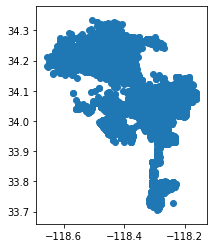

In [49]:
homeless_suspects_gdf.plot()

In [50]:
homeless_suspects_gdf.crs = ({'init': 'epsg:4326'})

In [51]:
homeless_suspects_gdf.to_crs({'init': 'epsg:3310'}, inplace=True)

In [52]:
homeless_suspects_gdf.head()

record_id date_reported date_occurred time_occurred division  \
1437675  171304592    01/10/2017    2017-01-10          1530       13   
1437676  170120212    07/20/2017    2017-07-20          1550        1   
1437722  170126156    10/03/2017    2017-10-03          1050        1   
1437732  171600882    06/29/2017    2017-06-29          1400       16   
1437800  171109384    04/22/2017    2017-04-22          0800       11   

        division_name reporting_district part_type crime_code  \
1437675        Newton               1391         1        440   
1437676       Central                142         2        740   
1437722       Central                119         1        440   
1437732      Foothill               1681         1        761   
1437800     Northeast               1123         2        900   

                                    crime_code_description  \
1437675                 Theft plain - petty ($950 & under)   
1437676  Vandalism - felony ($400 & over, all church va...   
1437722                 Theft plain - petty ($950 & under)   
1437732                                    Brandish weapon   
1437800                           Violation of court order   

                             modus_operandi_code  victim_age victim_sex  \
1437675                 2000 1814 1026 2004 0344          20     Female   
1437676                           1402 0329 2004          26       Male   
1437722                           0344 0910 2004          23     Female   
1437732  0421 0302 2004 1822 1256 0334 1407 1419          26       Male   
1437800                 2004 0561 0432 1202 1236          68     Female   

        victim_descent premises_code                  premises_description  \
1437675              B           101                                Street   
1437676              H           101                                Street   
1437722              W           215  Train depot/terminal, other than mta   
1437732              H           109                       Park/playground   
1437800              H           210                  Restaurant/fast food   

        weapon_code weapon_description status_code status_code_description  \
1437675         nan                NaN          IC             Invest Cont   
1437676         nan                NaN          AA            Adult Arrest   
1437722         nan                NaN          IC             Invest Cont   
1437732       101.0           Revolver          AA            Adult Arrest   
1437800         nan                NaN          AO             Adult Other   

        crm_cd_1 crm_cd_2 crm_cd_3 crm_cd_4  \
1437675      440      nan      nan      nan   
1437676      740      998      nan      nan   
1437722      440      nan      nan      nan   
1437732      761      998      nan      nan   
1437800      900      nan      nan      nan   

                                         address  \
1437675          66TH                         ST   
1437676                               INDUSTRIAL   
1437722   800 N  ALAMEDA                      ST   
1437732          ALLEGHENY                    ST   
1437800  3100    GLENDALE                     BL   

                            cross_street  latitude  longitude  year quarter  \
1437675                         BROADWAY   33.9798  -118.2783  2017       1   
1437676                            MATEO   34.0519  -118.2531  2017       3   
1437722                              NaN   34.0563  -118.2374  2017       4   
1437732  LAUREL CANYON                BL   34.2299  -118.4030  2017       2   
1437800                              NaN   34.1162  -118.2627  2017       2   

        day month   weekday monthname descent_description hour minute  \
1437675  10     1   Tuesday   January               Black   15     30   
1437676  20     7  Thursday      July            Hispanic   15     50   
1437722   3    10   Tuesday   October               White   10     50   
1437732  29     6  Thursday      June            Hispa

In [53]:
homeless_suspects_shelters = gpd.sjoin(homeless_suspects_gdf, dissolvedshelters, op='within')

//anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:3310'} != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [ ]:
crimes_shelters = gpd.sjoin(crimes_clipped, dissolvedshelters, op='within')

In [ ]:
homeless_suspects_shelters.crs = ({'init': 'epsg:4326'})
homeless_suspects_shelters.to_crs({'init': 'epsg:4326'})
crimes_shelters.crs = ({'init': 'epsg:4326'})
crimes_shelters.to_crs({'init': 'epsg:4326'})

In [ ]:
homeless_suspects_shelters.to_file('output/homeless_suspects_shelters.geojson', driver='GeoJSON')

In [ ]:
homeless_suspects_shelters.crs

### Convert buffered shelters back to 4326

In [ ]:
la_shelters.crs = {'init': 'epsg:3310'}

In [ ]:
la_shelters.to_crs({'init': 'epsg:4326'}, inplace=True)

In [ ]:
la_shelters.to_file('output/la_shelters_buffers.geojson', driver='GeoJSON')